In [117]:
# We will use some technique for ensuring that we get reproducable results.

import os

os.environ['PYTHONHASHSEED'] = str(323)

from tensorflow import random as tfrand
import numpy as np
import random as rn
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout, GRU, Conv1D, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error


## Important Notes. Read Before Run:

The whole notebook was tested in a **Microsoft Azure ML Studio** for obtaining computation advantages, and for better performance overall. 
All models, have been also saved on a private run as *hd5* files and are available. So if needed, I will be happy to provide.

Apart from that, the cells that follow, is an attempt by using tensorflow 2 techniques of ensuring than we get similar results. 

*** Attention

I am writing **similar** results and not **identical**. The reason is because some models have dropout layers that have some randomness
of which data is ignored, randomly. For that we can do nothing, the same for the fact that we run in gpu, and from that alone some
randomness is included, but we can control the random weights initialization, by creating the seeds we will see later on.

*** Azure Environment details

Computation unit used: Nvidia GPU 6 cores, 56 GB ram

In [119]:
# Create Some random seeds, as default, some models that performed extremely well, they have their own "dedicated" seeds, since I didn't
# want to lose them.

def reset_seeds():
    os.environ['PYTHONHASHSEED'] = str(323)
    np.random.seed(64)
    tfrand.set_seed(65)
    rn.seed(66)

reset_seeds()

In [120]:
# load data
stock_set = pd.read_csv('apple_stock_data.csv')
stock_set.head()

,Date,Close/Last,Volume,Open,High,Low
0,05/07/2021,$130.21,78973270,$130.85,$131.2582,$129.475
1,05/06/2021,$129.74,78128330,$127.89,$129.75,$127.13
2,05/05/2021,$128.1,84000900,$129.2,$130.45,$127.97
3,05/04/2021,$127.85,137564700,$131.19,$131.4899,$126.7
4,05/03/2021,$132.54,75135100,$132.04,$134.07,$131.83


In [121]:
# Take close/last column and convert it to float then reverse it since the latest data has to be last chronologically
stock_values = stock_set['Close/Last'].apply(lambda x: x[1:]).astype('float')
reversed_stocks = stock_values[::-1]

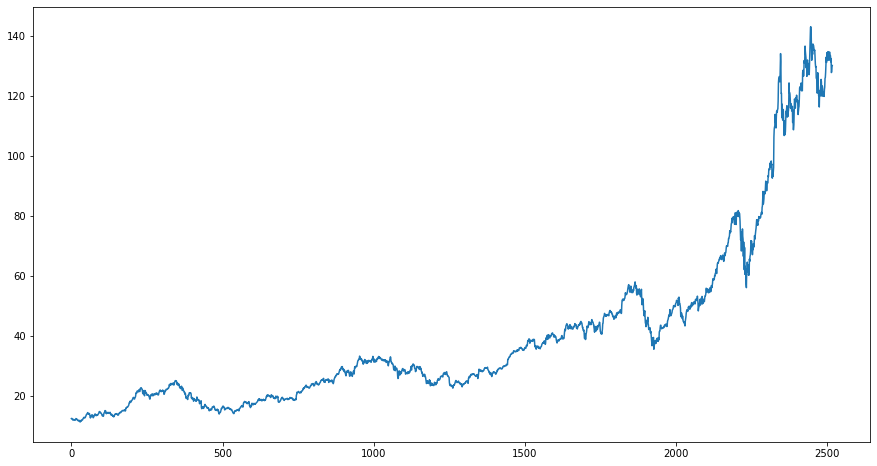

In [122]:
# Let's see our plot before our transformations apply

plt.figure(figsize=(15, 8))
plt.plot(reversed_stocks.index[::-1], np.array(reversed_stocks))
plt.show()

### Visualization Note

This is a pattern that happens with most tech companies. Their stocks appeared to be *flat* for some time, and then along with the
technological revolution and the *fourth industrial revolution* came also the bloosom of their stock price as well. 

From recurrent perspective it is a bit worrysome that most of the training set will be with the stock being flat, and the test set, on
a wild climbing. We will see how the models perform and evaluate later on, but we will keep that in mind.

In [123]:
# reshape stock column, preprocess, and scale
stocks_reshaped = np.array(reversed_stocks).reshape(-1, 1)
scaler = MinMaxScaler()
stocks_scaled = scaler.fit_transform(stocks_reshaped)
stocks_scaled

array([[0.00874081],
       [0.00924195],
       [0.00864073],
       ...,
       [0.88582138],
       [0.89825517],
       [0.90181852]])

In [124]:
# We create our own train test split function, pass total days (length of values) as first prop, the size of each sequence then,
# which indicates based on how many days in the past, we will predict the outcome for the given day. And last the proportion of the
# training size. It returns splits for the training set, test set and validation set. Prints also the length to ensure that nothing
# was lost due to round function or anything else

def create_sets(total_days, look_back, training_set_size):
    X_total = [stocks_scaled[i - look_back: i, 0] for i in range(look_back, total_days)]
    y_total = stocks_scaled[look_back: total_days]

    train_days = round(total_days * training_set_size)

    X_train = X_total[0:train_days]
    y_train = scaler.inverse_transform(y_total[0:train_days])

    X_test = X_total[train_days:]
    y_test = scaler.inverse_transform(y_total[train_days:])

# convert to numpy array and do some proper reshape before input
    validation_start = len(X_train) - len(X_test)

    X_train = np.array(X_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    y_test = np.array(y_test)
    X_validation = X_train[validation_start: X_train.shape[0]]
    y_validation = y_train[validation_start:X_train.shape[0]]

    # print and ensure that X and Y labels have the same length across train, test and validation sets

    print(X_train.shape)
    print(X_test.shape)
    print(len(y_train))
    print(len(y_test))
    print(len(X_validation))
    print(len(y_validation))
    
    return (X_train, y_train, X_test, y_test, X_validation, y_validation)

## Start Notes

We will start with what I call a **classic Machine Learning Approach**. We will split the train and the test set to 80/20, although there
is still the danger of testing data to contain patterns (and the economical erruption) that train set has not seen yet. 

That being said. We will try to predict the next 484 working days (which is almost 2 years) on a day by day sequence of course. Each day will
be predicted based on the last 20 working days. We picked this number because it represent *1 month* of the stock market and it should b
indicative of what happens. 

We can reset and choose new params if things don't work out, or if we want to experiment, and improve our precision.

In [125]:
# Create the set described on the above markdown cell
X_train, y_train, X_test, y_test, X_validation, y_validation = create_sets(stock_set.shape[0], 20, 0.8)

(2014, 20, 1)
(483, 20, 1)
2014
483
483
483


Let's have an a 2 layer LSTM model and use it as an inital benchmark to compare with other data later on.

In [130]:
model = Sequential()

model.add(LSTM(units=96, input_shape=(20, 1), recurrent_dropout=0.05, return_sequences=True))
model.add(LSTM(units=64, recurrent_dropout=0.05))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mae')

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_validation, y_validation))

Train on 2014 samples, validate on 483 samples
Epoch 1/100
2014/2014 [==============================] - 3s 2ms/step - loss: 17.1670 - val_loss: 30.2941
Epoch 2/100
2014/2014 [==============================] - 2s 1ms/step - loss: 12.5988 - val_loss: 26.4914
Epoch 3/100
2014/2014 [==============================] - 2s 1ms/step - loss: 10.4336 - val_loss: 22.8954
Epoch 4/100
2014/2014 [==============================] - 2s 1ms/step - loss: 8.4820 - val_loss: 19.5443
Epoch 5/100
2014/2014 [==============================] - 2s 1ms/step - loss: 6.3115 - val_loss: 16.4578
Epoch 6/100
2014/2014 [==============================] - 2s 1ms/step - loss: 5.1579 - val_loss: 13.6867
Epoch 7/100
2014/2014 [==============================] - 2s 1

In [131]:
test_loss = model.evaluate(X_test, y_test)
predicted = model.predict(X_test)
test_loss

483/483 [==============================] - 0s 259us/step


34.172177766914444

In [133]:
def create_plot(actual, predictions, time, ticks, y_limits):
    plt.figure(figsize=(12, 5))
    plt.title('Prediction Visualization')
    plt.plot(time, actual)
    plt.plot(time, predictions)
    plt.xlabel('Days Ahead')
    plt.ylabel('Apple Stock Prices')
    plt.xticks(ticks=ticks, labels=ticks)
    plt.ylim(y_limits[0], y_limits[1])
    plt.legend('upper right', labels=['Actual Apple Stock Prices', 'Predicted Stock Prices'])
    plt.show()

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  del sys.path[0]


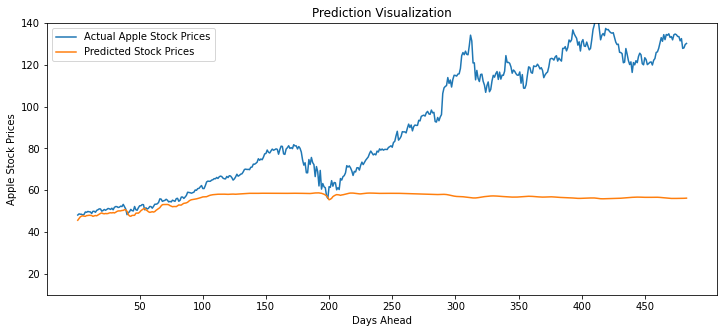

In [135]:
days_full = np.arange(1, 484)
ticks_full = np.arange(50, 483, 50)

create_plot(y_test, predicted, days_full, ticks_full, [10, 140])

## First Notes and Reactions

At first glance, it feels that our model failed miserably. Is not only the fact that the mean absolute error seems large (having an average
difference of approx. 35$ from the actual stock price on a given day is a total miss), but it's also the difference between the validation
set and the test set, that makes us feel, we need to change our approach. 

We will try out adding some dropouts and generalize better with the next one. We will add a bigger general dropout as we would like the model
to forget some eras of apples lower prices, and generalize. We will keep relatively low the recurrent dropout since we believe that each
sequence should have an important say to the predicted price calulcation.

Let's see.

In [136]:
model = Sequential()

model.add(LSTM(units=96, input_shape=(20, 1), dropout=0.4, recurrent_dropout=0.1, return_sequences=True))
model.add(LSTM(units=64, dropout=0.4, recurrent_dropout=0.1))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mae')

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_validation, y_validation))

Train on 2014 samples, validate on 483 samples
Epoch 1/100
2014/2014 [==============================] - 3s 2ms/step - loss: 16.9842 - val_loss: 29.8130
Epoch 2/100
2014/2014 [==============================] - 2s 1ms/step - loss: 12.2393 - val_loss: 25.9430
Epoch 3/100
2014/2014 [==============================] - 2s 1ms/step - loss: 10.2092 - val_loss: 22.4423
Epoch 4/100
2014/2014 [==============================] - 2s 1ms/step - loss: 9.2236 - val_loss: 19.6679
Epoch 5/100
2014/2014 [==============================] - 2s 1ms/step - loss: 9.0497 - val_loss: 19.2736
Epoch 6/100
2014/2014 [==============================] - 2s 1ms/step - loss: 8.7549 - val_loss: 16.7442
Epoch 7/100
2014/2014 [==============================] - 2s 1ms

In [137]:
test_loss = model.evaluate(X_test, y_test)
predicted = model.predict(X_test)
test_loss

483/483 [==============================] - 0s 266us/step


42.329665569044785

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  del sys.path[0]


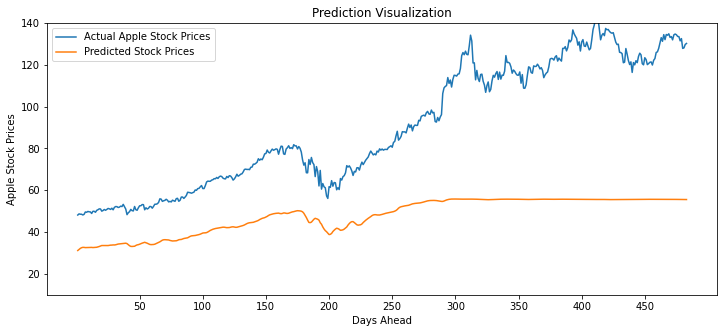

In [138]:
create_plot(y_test, predicted, days_full, ticks_full, [10, 140])

## Notes

Well that didn't help either. Now not only we fail to catch the stomr after day 100, but we are also innacurate during the early days.

## Conclusion and next steps

The difference error is obviously big, and we can see now why. Although the model behaves good during the first 100 test days (approx 100 working
days correspond to 5 months) it really goes off when Apple stock booms, which we may know it looks natural due to technological explosion,
but it's not natural for the model because previous data and specifically data the model has been trained on, didn't include this kind of
explosion.

This is even more obvious, if someone takes a look at the validation mean absolute error and the test mean absolute error. Because the validation
set does not include any kind of *unusual* activity, the error is way less (sometimes even less than 1 $) than on the test set.

## Further Notes and new approach

That means that because our testing set is way too large to predict, and because the whole expansion actually takes place within the test_set,
it's not easy to predict from the training set which was flat. Thus we will take a **different approach** from now on than usual ML approach
of 80/20 split. 

We will include most of the past to the training data, and for sure a big part of the expansion. And we will try to predict the next 3 months
again day by day. That will leave us with a training set of 97%, which may seems a lot, but actually trying to predict a quarter of a financial
year is more of a relistic **real-world** broker approach. 

At first we will begin with simpler models, see if we can get a reduction of error only due to data, and then we will try to optimize
our model, and see how it goes.

In [142]:
X_train, y_train, X_test, y_test, X_validation, y_validation = create_sets(stock_set.shape[0], 20, 0.97)

(2441, 20, 1)
(56, 20, 1)
2441
56
56
56


In [143]:
simple = Sequential()

simple.add(SimpleRNN(units=64, input_shape=(20, 1), dropout=0.1, recurrent_dropout=0.15, activation='tanh'))
simple.add(Dense(1))
simple.compile(optimizer='rmsprop', loss='mae')

simple.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_validation, y_validation))

Train on 2441 samples, validate on 56 samples
Epoch 1/200
2441/2441 [==============================] - 1s 390us/step - loss: 29.7860 - val_loss: 116.7679
Epoch 2/200
2441/2441 [==============================] - 1s 258us/step - loss: 22.8532 - val_loss: 111.7779
Epoch 3/200
2441/2441 [==============================] - 1s 258us/step - loss: 19.7322 - val_loss: 107.2027
Epoch 4/200
2441/2441 [==============================] - 1s 256us/step - loss: 18.0666 - val_loss: 103.5339
Epoch 5/200
2441/2441 [==============================] - 1s 274us/step - loss: 17.5435 - val_loss: 101.6766
Epoch 6/200
2441/2441 [==============================] - 1s 258us/step - loss: 17.4999 - val_loss: 101.3666
Epoch 7/200
2441/2441 [==============================] - 1

In [144]:
test_loss = simple.evaluate(X_test, y_test)
predicted = simple.predict(X_test)
print(test_loss)

56/56 [==============================] - 0s 110us/step
6.15987355368478


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  del sys.path[0]


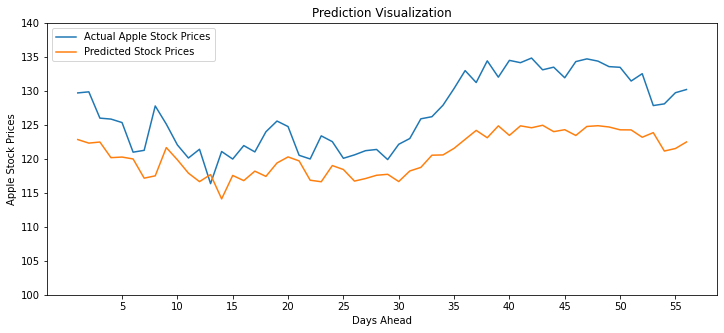

In [147]:
days = np.arange(1, 57)
x_ticks = np.arange(5, 57, 5)
create_plot(y_test, predicted, days, x_ticks, [100, 140])

Okay, it seems definitely better, still there is some room for improvement though, but at least predictions, seem to follow and understand
the trending line, although a bit off after the last rise.

Let's see some more complex ones, and how they behave.

In [148]:
os.environ['PYTHONHASHSEED'] = str(105)
np.random.seed(100)
tfrand.set_seed(75)
rn.seed(85)

model = Sequential()

model.add(LSTM(units=96, input_shape=(20, 1), recurrent_dropout=0.05, return_sequences=True))
model.add(LSTM(units=64, recurrent_dropout=0.05))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mae')
# we use the last 20% of training data as validation set

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_validation, y_validation))

Train on 2441 samples, validate on 56 samples
Epoch 1/100
2441/2441 [==============================] - 3s 1ms/step - loss: 26.8182 - val_loss: 115.2527
Epoch 2/100
2441/2441 [==============================] - 3s 1ms/step - loss: 21.8627 - val_loss: 110.6047
Epoch 3/100
2441/2441 [==============================] - 3s 1ms/step - loss: 18.7957 - val_loss: 105.9883
Epoch 4/100
2441/2441 [==============================] - 3s 1ms/step - loss: 15.7756 - val_loss: 101.7380
Epoch 5/100
2441/2441 [==============================] - 3s 1ms/step - loss: 13.8201 - val_loss: 97.9696
Epoch 6/100
2441/2441 [==============================] - 3s 1ms/step - loss: 12.1627 - val_loss: 94.0946
Epoch 7/100
2441/2441 [==============================] - 3

In [149]:
test_loss = model.evaluate(X_test, y_test)
predicted = model.predict(X_test)
test_loss

56/56 [==============================] - 0s 295us/step


2.88215742792402

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  del sys.path[0]


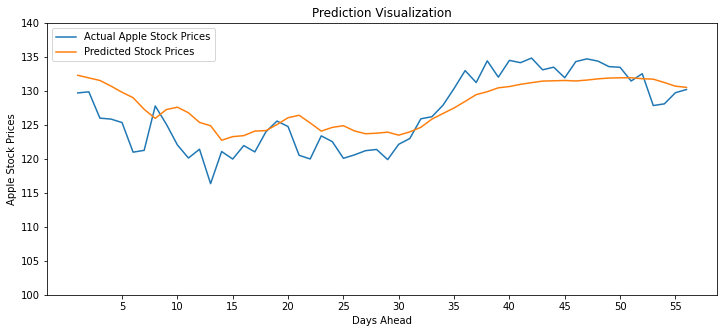

In [150]:
create_plot(y_test, predicted, days, x_ticks, [100, 140])

Ok, much better and a tough opponent to beat from now on. We will try and have more complex, a GRU try, and a Convolutional approach
to clean up things. Let's see how we go.

In [88]:
os.environ['PYTHONHASHSEED'] = str(205)
np.random.seed(200)
tfrand.set_seed(175)
rn.seed(185)

model = Sequential()

model.add(LSTM(units=64, input_shape=(20, 1), return_sequences=True))
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=64))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mae')

model.fit(X_train, y_train, epochs=120, batch_size=32, validation_data=(X_validation, y_validation))

Train on 2441 samples, validate on 56 samples
Epoch 1/120
2441/2441 [==============================] - 6s 3ms/step - loss: 26.3575 - val_loss: 114.5558
Epoch 2/120
2441/2441 [==============================] - 5s 2ms/step - loss: 21.3595 - val_loss: 109.8397
Epoch 3/120
2441/2441 [==============================] - 5s 2ms/step - loss: 18.7603 - val_loss: 105.2864
Epoch 4/120
2441/2441 [==============================] - 5s 2ms/step - loss: 15.3519 - val_loss: 101.0759
Epoch 5/120
2441/2441 [==============================] - 5s 2ms/step - loss: 13.4559 - val_loss: 97.2649
Epoch 6/120
2441/2441 [==============================] - 5s 2ms/step - loss: 11.8641 - val_loss: 93.4793
Epoch 7/120
2441/2441 [==============================] -

In [89]:
test_loss = model.evaluate(X_test, y_test)
predicted = model.predict(X_test)
test_loss

56/56 [==============================] - 0s 535us/step


3.7757787704467773

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  del sys.path[0]


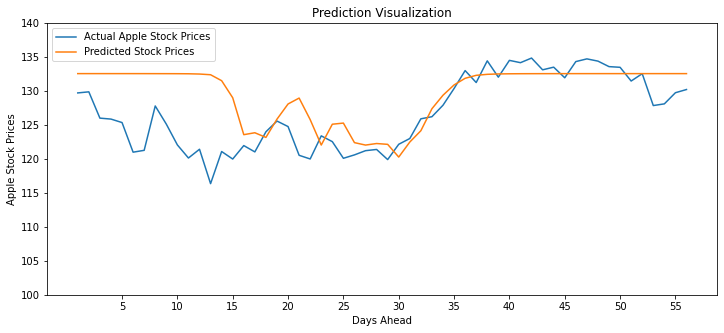

In [90]:
create_plot(y_test, predicted, days, x_ticks, [100, 140])

In [94]:
os.environ['PYTHONHASHSEED'] = str(700)
np.random.seed(900)
tfrand.set_seed(575)
rn.seed(666)

model = Sequential()

model.add(GRU(units=64, input_shape=(20, 1), return_sequences=True))
model.add(GRU(units=64, return_sequences=True))
model.add(GRU(units=64, return_sequences=True))
model.add(GRU(units=64))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mae')
# we use the last 20% of training data as validation set

model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_validation, y_validation))

Train on 2441 samples, validate on 56 samples
Epoch 1/200
2441/2441 [==============================] - 8s 3ms/step - loss: 26.5539 - val_loss: 115.0162
Epoch 2/200
2441/2441 [==============================] - 6s 2ms/step - loss: 21.6592 - val_loss: 110.2905
Epoch 3/200
2441/2441 [==============================] - 6s 2ms/step - loss: 19.0625 - val_loss: 105.8263
Epoch 4/200
2441/2441 [==============================] - 6s 2ms/step - loss: 17.7951 - val_loss: 102.5397
Epoch 5/200
2441/2441 [==============================] - 6s 2ms/step - loss: 17.5670 - val_loss: 101.8107
Epoch 6/200
2441/2441 [==============================] - 6s 2ms/step - loss: 15.3951 - val_loss: 99.0400
Epoch 7/200
2441/2441 [==============================] -

In [95]:
test_loss = model.evaluate(X_test, y_test)
predicted = model.predict(X_test)
test_loss

56/56 [==============================] - 0s 677us/step


3.6802665506090437

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  del sys.path[0]


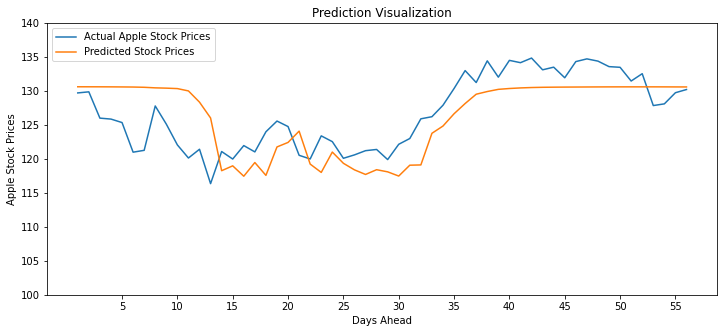

In [96]:
create_plot(y_test, predicted, days, x_ticks, [100, 140])

In [99]:
os.environ['PYTHONHASHSEED'] = str(21)
np.random.seed(22)
tfrand.set_seed(25)
rn.seed(28)

model = Sequential()

model.add(Conv1D(64, 5, activation='relu', input_shape=(20, 1)))
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 5, activation='relu'))
model.add(LSTM(units=96, input_shape=(20, 1), recurrent_dropout=0.05, return_sequences=True))
model.add(LSTM(units=64, recurrent_dropout=0.05))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mae')

model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_validation, y_validation))

Train on 2441 samples, validate on 56 samples
Epoch 1/200
2441/2441 [==============================] - 1s 590us/step - loss: 30.5123 - val_loss: 117.9015
Epoch 2/200
2441/2441 [==============================] - 0s 183us/step - loss: 24.3375 - val_loss: 114.1178
Epoch 3/200
2441/2441 [==============================] - 0s 181us/step - loss: 21.4168 - val_loss: 110.4900
Epoch 4/200
2441/2441 [==============================] - 0s 182us/step - loss: 18.4638 - val_loss: 106.7669
Epoch 5/200
2441/2441 [==============================] - 0s 186us/step - loss: 16.2102 - val_loss: 103.2676
Epoch 6/200
2441/2441 [==============================] - 0s 184us/step - loss: 14.4526 - val_loss: 99.7949
Epoch 7/200
2441/2441 [==============================] -

In [100]:
test_loss = model.evaluate(X_test, y_test)
predicted = model.predict(X_test)
test_loss

56/56 [==============================] - 0s 113us/step


6.0367240224565775

### Final Note on CNN

So maybe it's only one run, but it didn't seem to help by filtering out and pooling some data, to reduce the error.
It's also very small margin of error, and to improve it below the level of 2$ should be a daunting task anyway.

### Generic Notes

After data filtering and pruning to more relevant days, most of the models generalized and got the trends well, but the double LSTM layer
with the small recurrent dropout really came as close as it gets. Hence is our winner for this assignment.